In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from six.moves import urllib
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import scale
import math
from matplotlib.pyplot import MultipleLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
DOWNLOAD_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
DATA_PATH = "datasets/ENB"

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

file_path = os.path.join(DATA_PATH, "ENB2012_data.xlsx")

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(DOWNLOAD_URL, file_path)
    
dataset = pd.read_excel(file_path)
dataset = dataset.drop('Y2',axis=1)
print(dataset)

       X1     X2     X3      X4   X5  X6   X7  X8     Y1
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84
..    ...    ...    ...     ...  ...  ..  ...  ..    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64

[768 rows x 9 columns]


In [3]:
rawData = dataset.values# Dataset of your chice
N, pp1 = rawData.shape
# Last column is target
X = np.matrix(rawData[:,0:pp1-1])
t = np.matrix(rawData[:,pp1-1]).T
print(X.shape, t.shape)

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2)

(768, 8) (768, 1)


In [4]:
def design_matrix(X, J=20):
  kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
  sig = np.std(X)
  U = np.zeros((X.shape[0],J))
  for i in range(X.shape[0]):
    for j in range(J):
       U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])/sig)
  return U

83.83873977263224 82.58045797526464


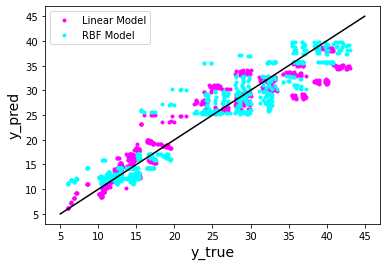

In [5]:
X_scaled = scale(X)
bias = np.ones(N)
X_scaled = np.c_[X_scaled, bias]

# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X_scaled.T @ X_scaled)) @ X_scaled.T * t
yh_lin = X_scaled@w

# Solve RBF model, predict and plot
U = design_matrix(X, 20)
w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * t
yh_rbf = np.dot(U,w)

plt.plot(t, yh_lin, '.', Color='magenta', label="Linear Model")
plt.plot(t, yh_rbf, '.', Color='cyan', label="RBF Model")
plt.plot([5,45], [5,45], '-', c='black')
plt.legend()
plt.xlabel("y_true", size=14)
plt.ylabel("y_pred", size=14)
print(np.linalg.norm(t-yh_lin), np.linalg.norm(t-yh_rbf))

In [14]:
w_lin = np.random.randn(9, 1)
epochs = 1000
batch_num = 20
learn_rate = 0.01

bias = np.ones(X_train.shape[0])
X_train_scaled = scale(X_train)
X_train_scaled = np.c_[X_train_scaled, bias]
bias = np.ones(X_test.shape[0])
X_test_scaled = scale(X_test)
X_test_scaled = np.c_[X_test_scaled, bias]

Train_loss_lin = np.zeros(epochs)
Test_loss_lin = np.zeros(epochs)

for n in range(epochs):
  x_index = np.random.randint(0, len(t_train), batch_num)
  gradient =  X_train_scaled[x_index].T.dot(X_train_scaled[x_index].dot(w_lin) - t[x_index]) * 2 / batch_num
  w_lin  = w_lin -  learn_rate * gradient
  Train_loss_lin[n] = mean_squared_error(X_train_scaled@w_lin, t_train)
  Test_loss_lin[n] = mean_squared_error(X_test_scaled@w_lin, t_test)

In [46]:
def rbf(J, decay_rate= 0.05):
  U_train = design_matrix(X_train, J)
  U_test = design_matrix(X_test, J)
  w_rbf = np.random.normal(loc=0, scale=1, size=J).reshape(-1, 1)
  epochs = 1000
  batch_num = 20
  learn_rate = 0.01

  Train_loss_rbf = np.zeros(epochs)
  Test_loss_rbf = np.zeros(epochs)
  for n in range(epochs):
    u_index = np.random.randint(0, len(t_train), batch_num)
    U_train[u_index].dot(w_rbf)
    gradient = U_train[u_index].T.dot(U_train[u_index].dot(w_rbf) - t_train[u_index]) * 2 / batch_num
    w_rbf  = (1-decay_rate)*w_rbf - learn_rate * gradient

    Train_loss_rbf[n] = mean_squared_error(U_train@w_rbf, t_train)
    Test_loss_rbf[n] = mean_squared_error(U_test@w_rbf, t_test)
  return Train_loss_rbf, Test_loss_rbf

In [58]:
Train_loss_rbf_5, Test_loss_rbf_5 = rbf(5, decay_rate= 0)
Train_loss_rbf_10, Test_loss_rbf_10 = rbf(10, decay_rate= 0)
Train_loss_rbf_20, Test_loss_rbf_20 = rbf(20, decay_rate= 0)

Train_loss_rbf_5_l2, Test_loss_rbf_5_l2 = rbf(5, decay_rate= 0.05)
Train_loss_rbf_10_l2, Test_loss_rbf_10_l2 = rbf(10, decay_rate= 0.05)
Train_loss_rbf_20_l2, Test_loss_rbf_20_l2 = rbf(20, decay_rate= 0.05)

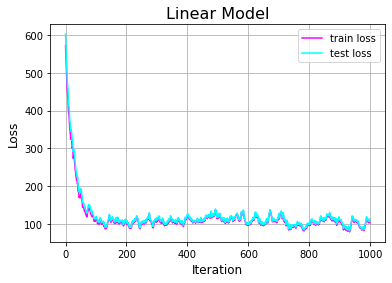

In [57]:
y_major_locator=MultipleLocator(100)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Train_loss_lin, Color='magenta', label='train loss')
ax.plot(Test_loss_lin, Color='cyan', label='test loss')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

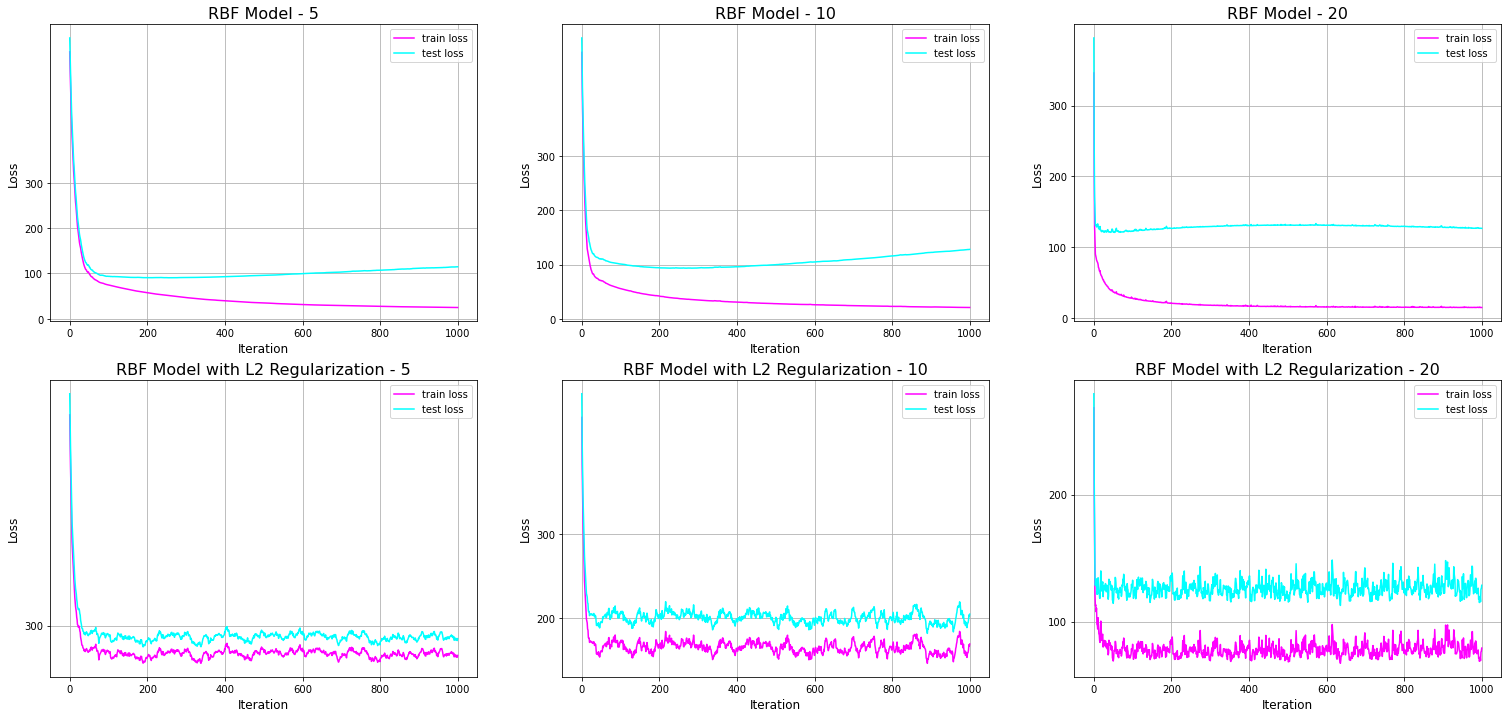

In [59]:
y_major_locator=MultipleLocator(100)
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(26,12))
# ax[0,0].plot(Train_loss_lin, Color='magenta', label='train loss')
# ax[0,0].plot(Test_loss_lin, Color='cyan', label='test loss')
# ax[0,0].set_xlabel("Iteration", fontsize=12)
# ax[0,0].set_ylabel("Loss", fontsize=12)
# ax[0,0].set_title("Linear Model", fontsize=16)
# ax[0,0].grid()
# ax[0,0].legend()
# ax[0,0].yaxis.set_major_locator(y_major_locator)
ax[0,0].plot(Train_loss_rbf_5, Color='magenta', label='train loss')
ax[0,0].plot(Test_loss_rbf_5, Color='cyan', label='test loss')
ax[0,0].set_xlabel("Iteration", fontsize=12)
ax[0,0].set_ylabel("Loss", fontsize=12)
ax[0,0].set_title("RBF Model - 5", fontsize=16)
ax[0,0].grid()
ax[0,0].legend()
ax[0,0].yaxis.set_major_locator(y_major_locator)
ax[0,1].plot(Train_loss_rbf_10, Color='magenta', label='train loss')
ax[0,1].plot(Test_loss_rbf_10, Color='cyan', label='test loss')
ax[0,1].set_xlabel("Iteration", fontsize=12)
ax[0,1].set_ylabel("Loss", fontsize=12)
ax[0,1].set_title("RBF Model - 10", fontsize=16)
ax[0,1].grid()
ax[0,1].legend()
ax[0,1].yaxis.set_major_locator(y_major_locator)
ax[0,2].plot(Train_loss_rbf_20, Color='magenta', label='train loss')
ax[0,2].plot(Test_loss_rbf_20, Color='cyan', label='test loss')
ax[0,2].set_xlabel("Iteration", fontsize=12)
ax[0,2].set_ylabel("Loss", fontsize=12)
ax[0,2].set_title("RBF Model - 20", fontsize=16)
ax[0,2].grid()
ax[0,2].legend()
ax[0,2].yaxis.set_major_locator(y_major_locator)

# ax[1,0].plot(Train_loss_lin, Color='magenta', label='train loss')
# ax[1,0].plot(Test_loss_lin, Color='cyan', label='test loss')
# ax[1,0].set_xlabel("Iteration", fontsize=12)
# ax[1,0].set_ylabel("Loss", fontsize=12)
# ax[1,0].set_title("Linear Model", fontsize=16)
# ax[1,0].grid()
# ax[1,0].legend()
# ax[1,0].yaxis.set_major_locator(y_major_locator)
ax[1,0].plot(Train_loss_rbf_5_l2, Color='magenta', label='train loss')
ax[1,0].plot(Test_loss_rbf_5_l2, Color='cyan', label='test loss')
ax[1,0].set_xlabel("Iteration", fontsize=12)
ax[1,0].set_ylabel("Loss", fontsize=12)
ax[1,0].set_title("RBF Model with L2 Regularization - 5", fontsize=16)
ax[1,0].grid()
ax[1,0].legend()
ax[1,0].yaxis.set_major_locator(y_major_locator)
ax[1,1].plot(Train_loss_rbf_10_l2, Color='magenta', label='train loss')
ax[1,1].plot(Test_loss_rbf_10_l2, Color='cyan', label='test loss')
ax[1,1].set_xlabel("Iteration", fontsize=12)
ax[1,1].set_ylabel("Loss", fontsize=12)
ax[1,1].set_title("RBF Model with L2 Regularization - 10", fontsize=16)
ax[1,1].grid()
ax[1,1].legend()
ax[1,1].yaxis.set_major_locator(y_major_locator)
ax[1,2].plot(Train_loss_rbf_20_l2, Color='magenta', label='train loss')
ax[1,2].plot(Test_loss_rbf_20_l2, Color='cyan', label='test loss')
ax[1,2].set_xlabel("Iteration", fontsize=12)
ax[1,2].set_ylabel("Loss", fontsize=12)
ax[1,2].set_title("RBF Model with L2 Regularization - 20", fontsize=16)
ax[1,2].grid()
ax[1,2].legend()
ax[1,2].yaxis.set_major_locator(y_major_locator)
plt.show()